# Predicting Return on Investment from Lending Club Loans

By: Scott Hongola

description

questions

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import featuretools as ft
from sklearn import tree 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.model_selection import cross_val_score
import os
import glob
from scipy.stats import zscore

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings(action="ignore")

In [161]:
current_path = os.getcwd()
print(current_path)

/Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club


In [162]:
cap_docs ='/Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club'

_list = glob.glob(os.path.join(cap_docs, '*.csv'))

file_list = []

for filename in _list:

    print("READING " + filename + "...")

    _df = pd.read_csv(filename)
    
    _df.drop(_df.columns[0], axis=1, inplace=True)   
    
    _df.drop(['member_id',
              'desc',
              'next_pymnt_d',
              'orig_projected_additional_accrued_interest',
              'hardship_status',
              'hardship_type',
              'hardship_reason',
              'deferral_term',
              'hardship_amount',
              'hardship_start_date',
              'hardship_end_date',
              'payment_plan_start_date',
              'hardship_length',
              'hardship_dpd',
              'hardship_loan_status',
              'hardship_payoff_balance_amount',
              'hardship_last_payment_amount',
              'debt_settlement_flag_date',
              'settlement_status',
              'settlement_date',
              'settlement_amount',
              'settlement_percentage',
              'settlement_term',
              'funded_amnt',
              'out_prncp',
              'total_pymnt',
              'total_pymnt_inv',
              'total_rec_prncp',
              'total_rec_int',
              'total_rec_late_fee',
              'recoveries',
              'collection_recovery_fee',
              'last_pymnt_d',
              'last_pymnt_amnt',
              'last_fico_range_high',
              'last_fico_range_low',
              'hardship_flag',
              'debt_settlement_flag',
              'pymnt_plan',
              'out_prncp_inv',
              'policy_code',
              'disbursement_method',
              'funded_amnt_inv'], axis=1, inplace=True)

    file_list.append(_df)
    
    lending_club = pd.concat(file_list)

print(lending_club.shape)

READING /Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club/2018Q3.csv...
READING /Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club/2018Q2.csv...
READING /Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club/2018Q1.csv...
READING /Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club/2017Q1.csv...
READING /Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club/2017Q3.csv...
READING /Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club/2017Q2.csv...
READING /Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club/2017Q4.csv...
READING /Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club/2016Q3.csv...
READING /Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/lending_club/2016Q2.csv...
READING /Users/scotthongola/Documents/Thinkful

In [163]:
lending_club.head()

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,141093697,30000,36 months,8.46%,946.480,A,A5,Mental Health Therapist,5 years,MORTGAGE,...,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,141090180,10000,36 months,7.84%,312.630,A,A4,NaN,NaN,OWN,...,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,141092241,4200,36 months,13.56%,142.660,C,C1,Database Marketing Coordinator,< 1 year,MORTGAGE,...,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,141092636,9000,36 months,6.11%,274.250,A,A1,NaN,NaN,OWN,...,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,141049499,6000,36 months,7.84%,187.580,A,A4,NaN,NaN,RENT,...,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [164]:
# verify that we did not get any duplicate rows by counting unique loan id
lending_club.id.value_counts().sort_values(ascending=True).head(3)

83890174     1
125845496    1
130043894    1
Name: id, dtype: int64

In [165]:
# view a sample of each column
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(lending_club.head())

          id  loan_amnt        term int_rate  installment grade sub_grade  \
0  141093697      30000   36 months    8.46%      946.480     A        A5   
1  141090180      10000   36 months    7.84%      312.630     A        A4   
2  141092241       4200   36 months   13.56%      142.660     C        C1   
3  141092636       9000   36 months    6.11%      274.250     A        A1   
4  141049499       6000   36 months    7.84%      187.580     A        A4   

                        emp_title emp_length home_ownership  annual_inc  \
0         Mental Health Therapist    5 years       MORTGAGE   70000.000   
1                             NaN        NaN            OWN   50000.000   
2  Database Marketing Coordinator   < 1 year       MORTGAGE   38500.000   
3                             NaN        NaN            OWN   25000.000   
4                             NaN        NaN           RENT   30000.000   

  verification_status issue_d loan_status  \
0     Source Verified  Sep-18      Issued

In [166]:
lending_club.info(108)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1244816 entries, 0 to 103545
Data columns (total 108 columns):
id                                     int64
loan_amnt                              int64
term                                   object
int_rate                               object
installment                            float64
grade                                  object
sub_grade                              object
emp_title                              object
emp_length                             object
home_ownership                         object
annual_inc                             float64
verification_status                    object
issue_d                                object
loan_status                            object
url                                    object
purpose                                object
title                                  object
zip_code                               object
addr_state                             object
dti          

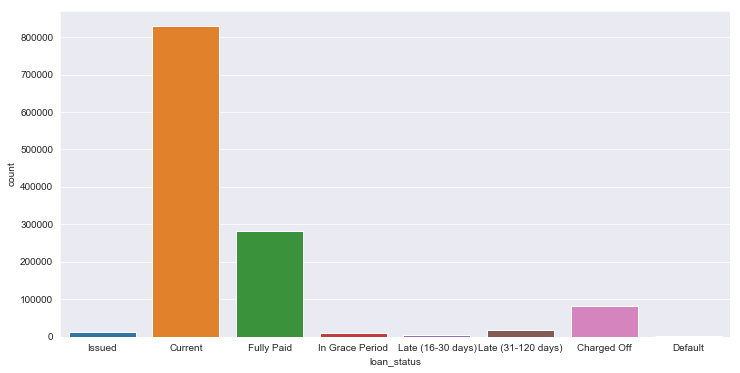

In [167]:
# visualize information to determine our target variable
plt.figure(figsize=(12,6))
sns.countplot(lending_club['loan_status'])
plt.show()

In [168]:
lending_club.loan_status.value_counts()

Current               829111
Fully Paid            283134
Charged Off            82099
Late (31-120 days)     19406
Issued                 13621
In Grace Period        10769
Late (16-30 days)       5811
Default                  865
Name: loan_status, dtype: int64

### Create a target variable

Since we are trying to predict which loans will be fully repaid and which ones will be charged off we need to drop the data of which we are unsure as to the result of fully paid or charged off (current, late, in grace period, issued) as well as create a target variable that captures the success of a loan in being fully repaid or one that is charged off / defaults.

In [169]:
default = ['Charged Off', 'Default']
paid = ['Fully Paid']

def target(status):
    if status in default:
        return 1
    if status in paid:
        return 0
    else:
        return -1
    
lending_club['target'] = lending_club['loan_status'].apply(target)

In [170]:
lending_club.target.value_counts()

-1    878718
 0    283134
 1     82964
Name: target, dtype: int64

In [171]:
lending_club = lending_club[lending_club['target'] != -1]

In [172]:
lending_club.info(109)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366098 entries, 78 to 103544
Data columns (total 109 columns):
id                                     int64
loan_amnt                              int64
term                                   object
int_rate                               object
installment                            float64
grade                                  object
sub_grade                              object
emp_title                              object
emp_length                             object
home_ownership                         object
annual_inc                             float64
verification_status                    object
issue_d                                object
loan_status                            object
url                                    object
purpose                                object
title                                  object
zip_code                               object
addr_state                             object
dti          

In [173]:
lending_club.shape

(366098, 109)

In [174]:
date_features = ['issue_d','earliest_cr_line','last_credit_pull_d','sec_app_earliest_cr_line']

lending_club[date_features] = lending_club[date_features].apply(lambda x: pd.to_datetime(x, format = '%b-%y'))
lending_club['int_rate'] = lending_club.int_rate.str.replace('%', '').astype(float)
lending_club['revol_util'] = lending_club.revol_util.str.replace('%', '').astype(float)

In [175]:
lending_club.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366098 entries, 78 to 103544
Columns: 109 entries, id to target
dtypes: datetime64[ns](4), float64(48), int64(41), object(16)
memory usage: 307.2+ MB


In [176]:
lending_club.describe(include='all')

,id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,target
count,366098.000,366098.000,366098,366098.000,366098.000,366098,366098,341534,341824,366098,...,9697.000,9697.000,9697.000,9544.000,9697.000,9697.000,9697.000,9697.000,3434.000,366098.000
unique,nan,nan,2,nan,nan,7,35,103049,11,5,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,nan,36 months,nan,nan,C,C1,Manager,10+ years,MORTGAGE,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,nan,280156,nan,nan,112504,25697,6430,123752,183012,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
first,nan,nan,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
last,nan,nan,NaN,nan,nan,NaN,NaN,NaN,NaN,NaN,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,93064168.179,14493.270,NaN,13.630,445.354,NaN,NaN,NaN,NaN,NaN,...,0.773,1.710,11.322,57.174,2.943,12.971,0.058,0.089,36.653,0.227
std,18169923.416,9195.577,NaN,5.354,282.062,NaN,NaN,NaN,NaN,NaN,...,1.108,1.851,6.556,26.688,3.228,8.438,0.451,0.428,24.259,0.419
min,55716.000,1000.000,NaN,5.310,30.120,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,77031933.500,7200.000,NaN,9.750,238.170,NaN,NaN,NaN,NaN,NaN,...,0.000,0.000,7.000,37.600,1.000,7.000,0.000,0.000,15.000,0.000


In [177]:
# prior to cleaning data look at basic stats on each feature
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(lending_club.describe(include='all'))

                  id  loan_amnt        term   int_rate  installment   grade  \
count     366098.000 366098.000      366098 366098.000   366098.000  366098   
unique           nan        nan           2        nan          nan       7   
top              nan        nan   36 months        nan          nan       C   
freq             nan        nan      280156        nan          nan  112504   
first            nan        nan         NaN        nan          nan     NaN   
last             nan        nan         NaN        nan          nan     NaN   
mean    93064168.179  14493.270         NaN     13.630      445.354     NaN   
std     18169923.416   9195.577         NaN      5.354      282.062     NaN   
min        55716.000   1000.000         NaN      5.310       30.120     NaN   
25%     77031933.500   7200.000         NaN      9.750      238.170     NaN   
50%     90511341.500  12000.000         NaN     12.790      371.240     NaN   
75%    106955812.500  20000.000         NaN     16.2

In [178]:
# see which features are missing data
missing = lending_club.isnull().sum()/lending_club.isnull().count()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(missing.sort_values(ascending=False))

sec_app_mths_since_last_major_derog   0.991
sec_app_revol_util                    0.974
revol_bal_joint                       0.974
sec_app_inq_last_6mths                0.974
sec_app_collections_12_mths_ex_med    0.974
sec_app_chargeoff_within_12_mths      0.974
sec_app_num_rev_accts                 0.974
sec_app_open_act_il                   0.974
sec_app_open_acc                      0.974
sec_app_mort_acc                      0.974
sec_app_earliest_cr_line              0.974
sec_app_fico_range_high               0.974
sec_app_fico_range_low                0.974
verification_status_joint             0.959
annual_inc_joint                      0.959
dti_joint                             0.959
mths_since_last_record                0.800
mths_since_recent_bc_dlq              0.755
mths_since_last_major_derog           0.714
mths_since_recent_revol_delinq        0.651
mths_since_last_delinq                0.485
il_util                               0.131
mths_since_recent_inq           

In [179]:
# create list to populate flags for missing data imputed
flags = ['sec_app_fico_range_low','mo_sin_old_il_acct','mths_since_rcnt_il','mths_since_recent_bc','dti','percent_bc_gt_75',
        'mths_since_last_delinq','mths_since_last_major_derog','mths_since_last_record','mths_since_recent_bc_dlq',
        'mths_since_recent_revol_delinq','mths_since_recent_inq','revol_util','inq_last_6mths','il_util',
        'bc_util','bc_open_to_buy','num_tl_120dpd_2m','emp_length','open_acc_6m','open_act_il','open_il_12m','open_il_24m',
        'total_bal_il','open_rv_12m','open_rv_24m','max_bal_bc','all_util','inq_fi','total_cu_tl','inq_last_12m','avg_cur_bal']

# create and fill columns for missing data that will be imputed
for col in flags:
    lending_club[col+'_missing'] = np.where(lending_club[col].isnull(), 0, 1)

# create fill list for columns to be filled with negative value
fill_cols_neg = ['mo_sin_old_il_acct','mths_since_rcnt_il','mths_since_recent_bc', 'dti','percent_bc_gt_75',
                 'all_util']
# check on utilization features as well for neg, revol_util, il_util, bc_util


# create fill list for columns to be filled with maximum
fill_cols_max = ['mths_since_last_delinq','mths_since_last_major_derog', 'sec_app_mths_since_last_major_derog',
                'mths_since_last_record','mths_since_recent_bc_dlq','mths_since_recent_revol_delinq',
                'mths_since_recent_inq']

# create fill list for columns to be filled with 0
fill_cols_zero = ['sec_app_revol_util','sec_app_fico_range_low','sec_app_fico_range_high','sec_app_inq_last_6mths',
                  'sec_app_mort_acc','sec_app_open_acc','sec_app_num_rev_accts','sec_app_open_act_il', 
                  'revol_util','inq_last_6mths','sec_app_chargeoff_within_12_mths','sec_app_collections_12_mths_ex_med',
                  'il_util','bc_util','bc_open_to_buy', 'num_tl_120dpd_2m','open_acc_6m','open_act_il','open_il_12m',
                  'open_il_24m','total_bal_il','open_rv_12m','open_rv_24m','max_bal_bc','inq_fi','total_cu_tl',
                  'inq_last_12m','avg_cur_bal']

# create fill list for columns to be filled with string
fill_cols_none = ['verification_status_joint', 'emp_title', 'title']

# impute data from above lists
for col in fill_cols_neg:
    lending_club.loc[:, col].fillna(-1, inplace=True) 

for col in fill_cols_max:
    lending_club.loc[:, col].fillna(lending_club[col].max() * 1.05, inplace=True)

for col in fill_cols_zero:
    lending_club.loc[:, col].fillna(0, inplace=True) 
    
for col in fill_cols_none:
    lending_club.loc[:, col].fillna('None', inplace=True) 

# fill joint columns with individual applicant data for certain joint applicant features   
lending_club['dti_joint'].fillna(lending_club['dti'], inplace=True)
lending_club['revol_bal_joint'].fillna(lending_club['revol_bal'], inplace=True)
lending_club['annual_inc_joint'].fillna(lending_club['annual_inc'], inplace=True)
lending_club['sec_app_earliest_cr_line'].fillna(lending_club['earliest_cr_line'], inplace=True)
lending_club['emp_length'].fillna(lending_club['emp_length'].mode().iloc[0], inplace=True)

In [180]:
# check our imputations to see if any features are still missing data
missing = lending_club.isnull().sum()/lending_club.isnull().count()
missing

id                                       0.000
loan_amnt                                0.000
term                                     0.000
int_rate                                 0.000
installment                              0.000
grade                                    0.000
sub_grade                                0.000
emp_title                                0.000
emp_length                               0.000
home_ownership                           0.000
annual_inc                               0.000
verification_status                      0.000
issue_d                                  0.000
loan_status                              0.000
url                                      0.000
purpose                                  0.000
title                                    0.000
zip_code                                 0.000
addr_state                               0.000
dti                                      0.000
delinq_2yrs                              0.000
earliest_cr_l

In [181]:
# create mean fico column
lending_club['fico_mean'] = (lending_club['fico_range_low'] + lending_club['fico_range_high']) / 2

# create mean second applicant fico column
lending_club['sec_app_fico_mean'] = (lending_club['sec_app_fico_range_low'] + lending_club['sec_app_fico_range_high']) / 2

# create integer month term column
lending_club['term_months'] = [36 if x == ' 36 months' else 60 for x in lending_club['term']]

# drop previous fico scores
lending_club.drop(['fico_range_low','fico_range_high','sec_app_fico_range_low','sec_app_fico_range_high'], axis=1, inplace=True)


In [182]:
emp_dict = {'< 1 year':0.5, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6,
                    '7 years':7, '8 years':8, '9 years':9, '10+ years':10}

lending_club['emp_length_int'] = lending_club['emp_length'].map(emp_dict)

lending_club.drop(['emp_length'], axis=1, inplace=True)

In [183]:
# get summary statistics for remaining dataframe after imputation
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(lending_club.describe(include='all'))

                  id  loan_amnt        term   int_rate  installment   grade  \
count     366098.000 366098.000      366098 366098.000   366098.000  366098   
unique           nan        nan           2        nan          nan       7   
top              nan        nan   36 months        nan          nan       C   
freq             nan        nan      280156        nan          nan  112504   
first            nan        nan         NaN        nan          nan     NaN   
last             nan        nan         NaN        nan          nan     NaN   
mean    93064168.179  14493.270         NaN     13.630      445.354     NaN   
std     18169923.416   9195.577         NaN      5.354      282.062     NaN   
min        55716.000   1000.000         NaN      5.310       30.120     NaN   
25%     77031933.500   7200.000         NaN      9.750      238.170     NaN   
50%     90511341.500  12000.000         NaN     12.790      371.240     NaN   
75%    106955812.500  20000.000         NaN     16.2

In [184]:
lending_club.info(128)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366098 entries, 78 to 103544
Data columns (total 140 columns):
id                                        int64
loan_amnt                                 int64
term                                      object
int_rate                                  float64
installment                               float64
grade                                     object
sub_grade                                 object
emp_title                                 object
home_ownership                            object
annual_inc                                float64
verification_status                       object
issue_d                                   datetime64[ns]
loan_status                               object
url                                       object
purpose                                   object
title                                     object
zip_code                                  object
addr_state                                obj

In [185]:
# check our imputations to see if any features are still missing data
missing = lending_club.isnull().sum()/lending_club.isnull().count()
missing

id                                       0.000
loan_amnt                                0.000
term                                     0.000
int_rate                                 0.000
installment                              0.000
grade                                    0.000
sub_grade                                0.000
emp_title                                0.000
home_ownership                           0.000
annual_inc                               0.000
verification_status                      0.000
issue_d                                  0.000
loan_status                              0.000
url                                      0.000
purpose                                  0.000
title                                    0.000
zip_code                                 0.000
addr_state                               0.000
dti                                      0.000
delinq_2yrs                              0.000
earliest_cr_line                         0.000
inq_last_6mth

# EDA

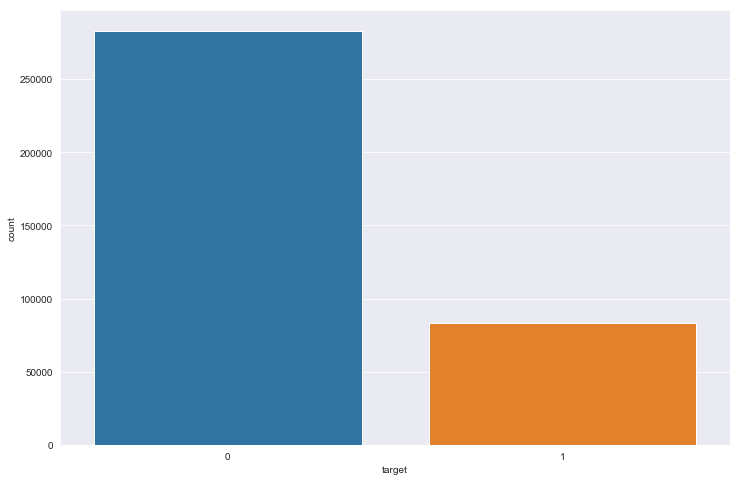

In [186]:
# vizualize target feature
plt.figure(figsize=(12,8))

sns.countplot(lending_club.target)
plt.show()

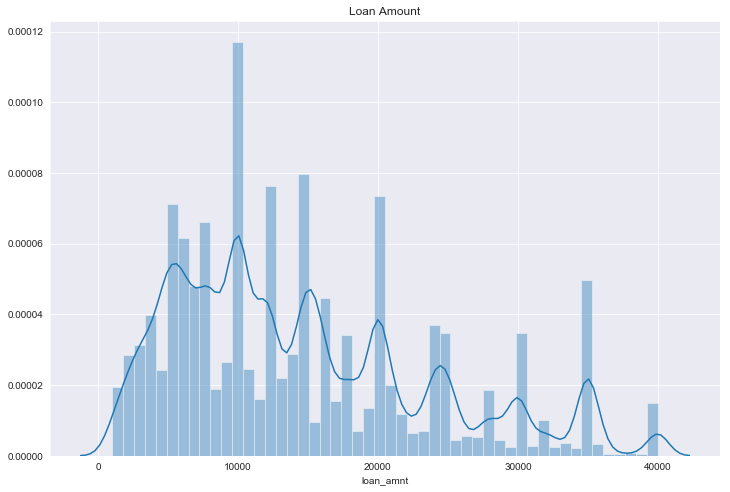

In [187]:
# see distribution of loan amount funded
plt.figure(figsize=(12,8))

sns.distplot(lending_club.loan_amnt)
plt.title("Loan Amount")
plt.show()

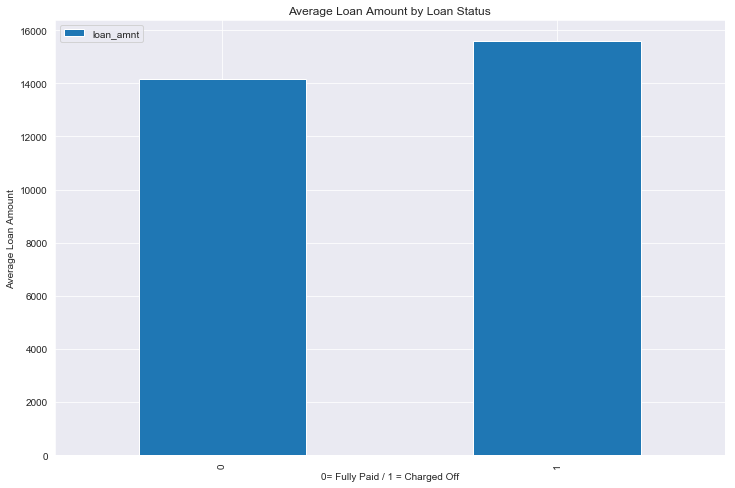

In [188]:
# Pivot dataframe by target variable to pull mean of loan amount
loan_type = pd.pivot_table(data=lending_club, index='target', values=['loan_amnt'], aggfunc='mean')

# Plot average loan amount size by target
loan_type.plot(kind='bar', figsize=(12,8))
plt.ylabel('Average Loan Amount')
plt.xlabel('0= Fully Paid / 1 = Charged Off')
plt.title('Average Loan Amount by Loan Status')
plt.show()

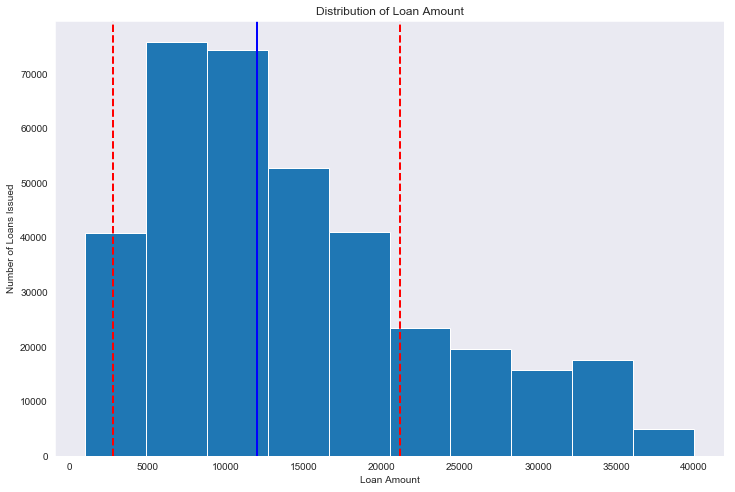

In [189]:
# Plot aanother distribution of loan amount
lending_club.loan_amnt.hist(figsize=(12,8), bins=10)
plt.axvline(lending_club.loan_amnt.median(), color='b', linestyle='solid', linewidth=2)
plt.axvline(lending_club.loan_amnt.median() + lending_club.loan_amnt.std(), color='red', linestyle='dashed', linewidth=2)
plt.axvline(lending_club.loan_amnt.median() - lending_club.loan_amnt.std(), color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Loan Amount')
plt.xlabel('Loan Amount')
plt.ylabel('Number of Loans Issued')
plt.grid(False)
plt.show()

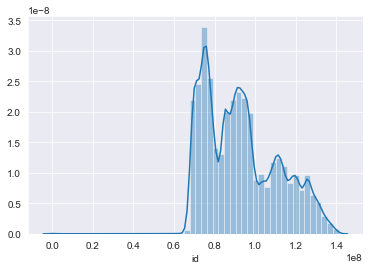

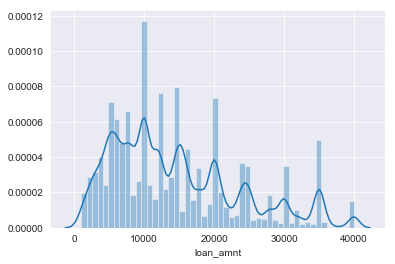

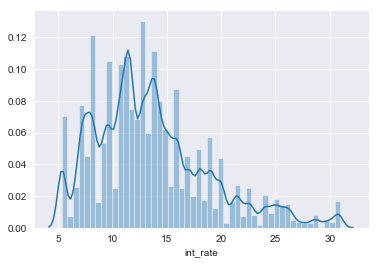

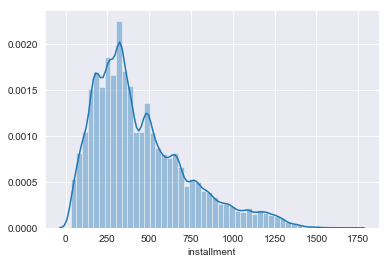

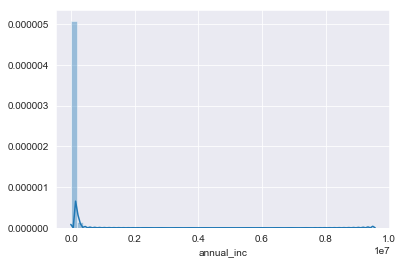

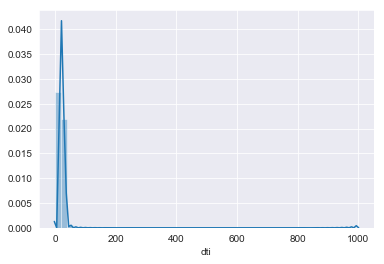

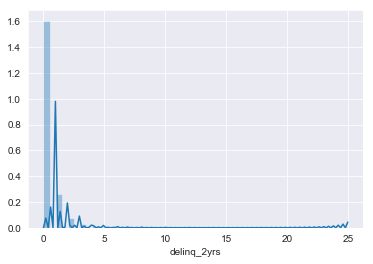

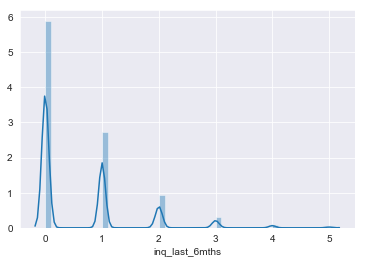

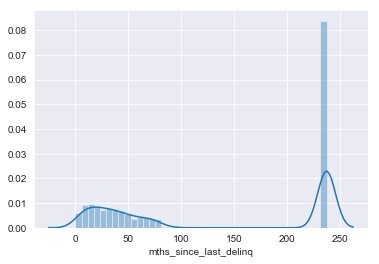

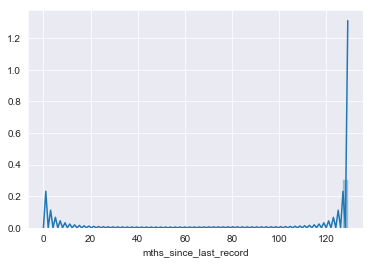

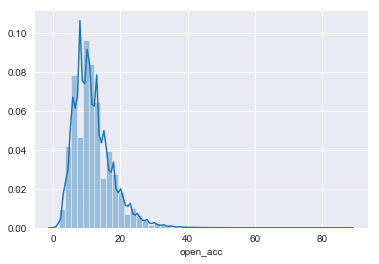

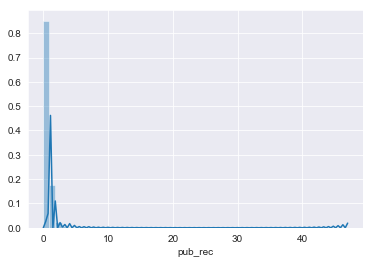

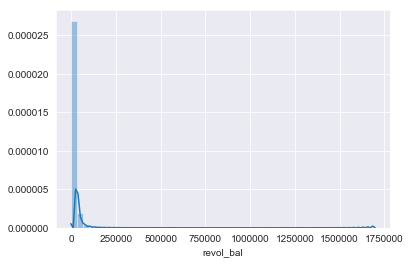

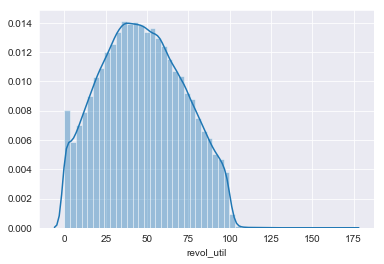

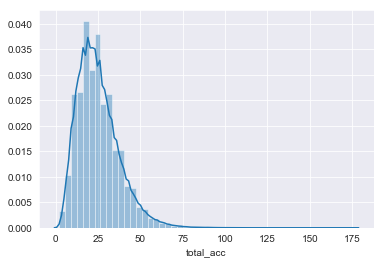

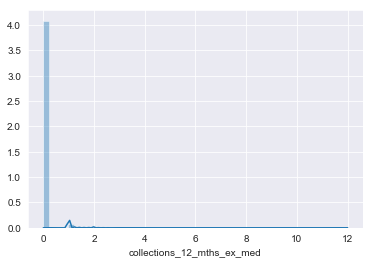

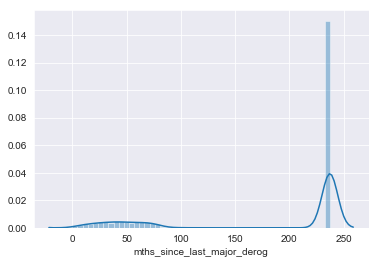

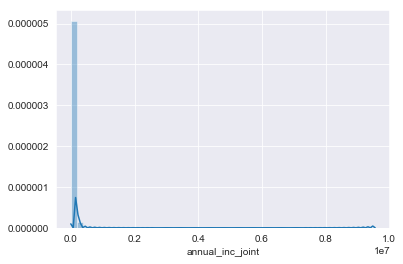

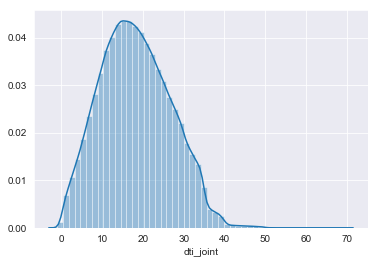

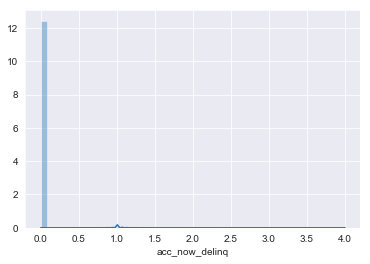

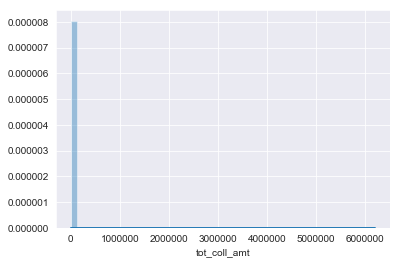

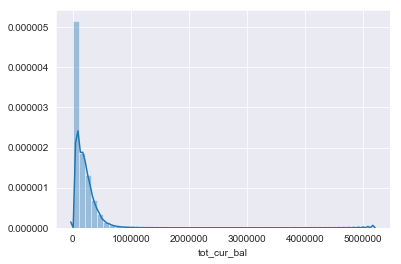

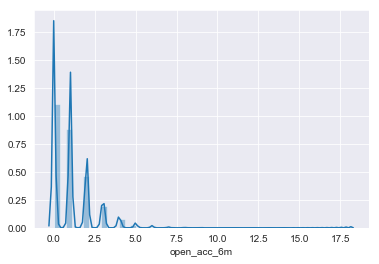

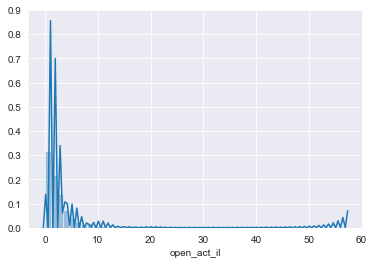

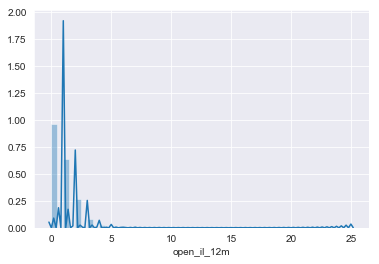

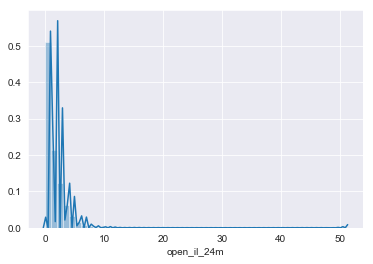

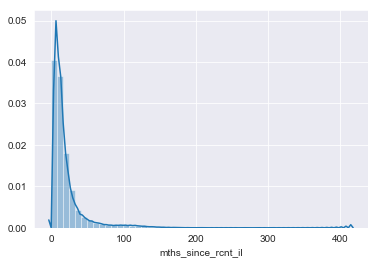

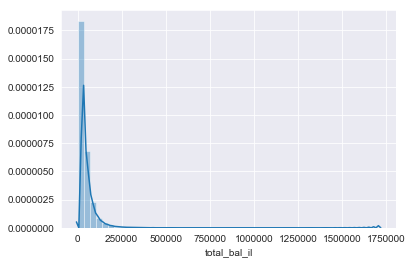

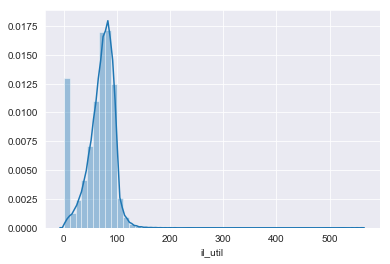

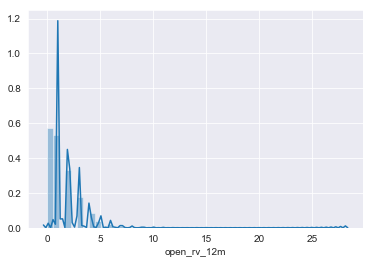

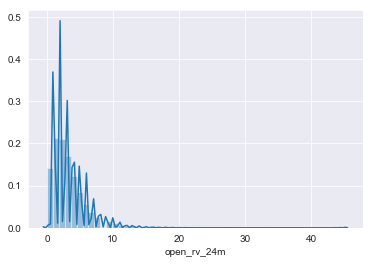

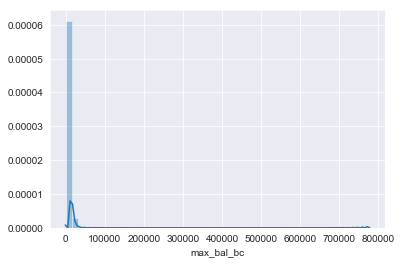

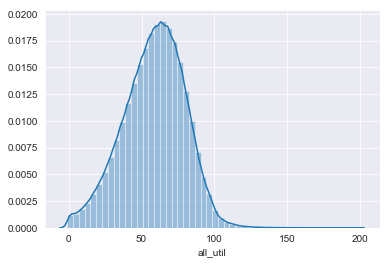

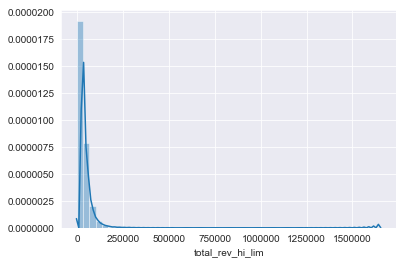

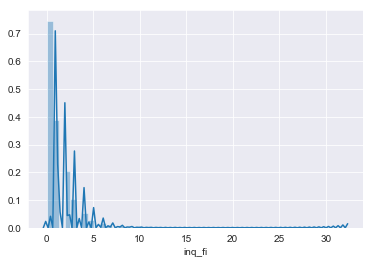

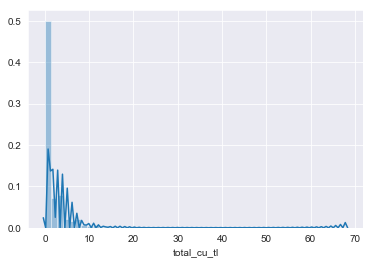

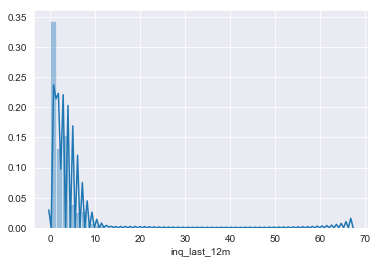

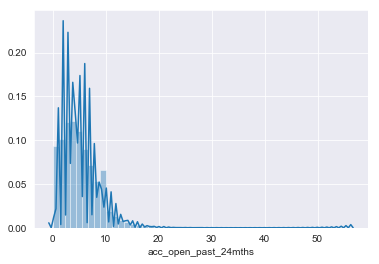

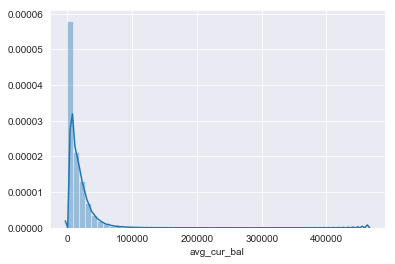

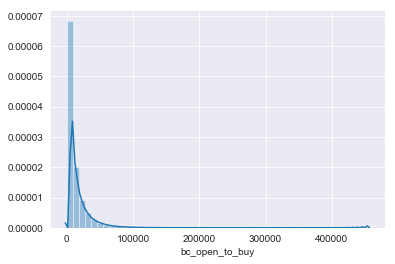

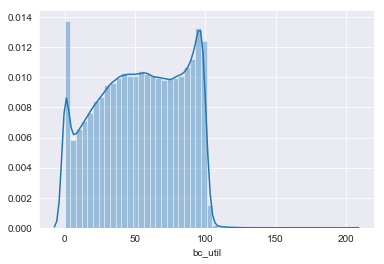

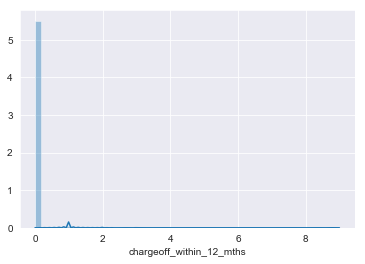

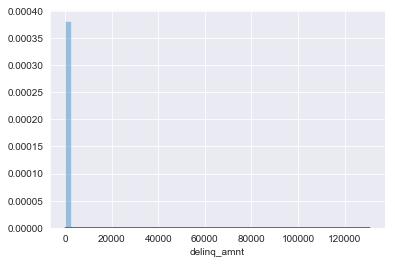

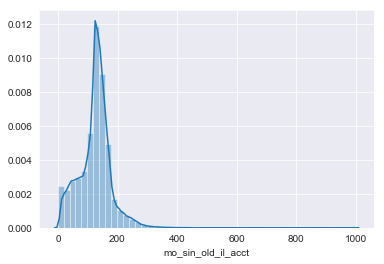

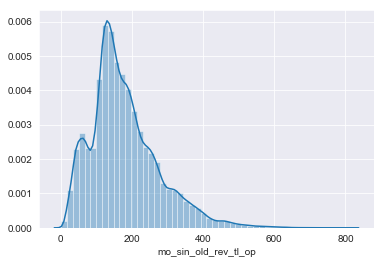

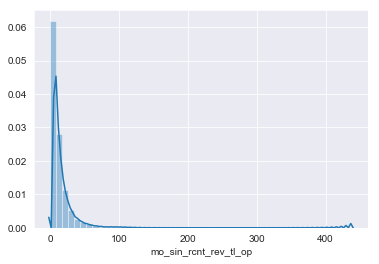

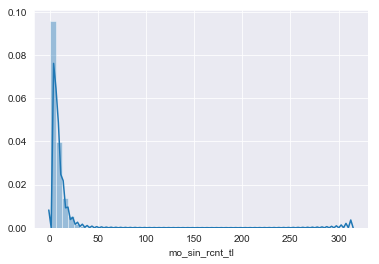

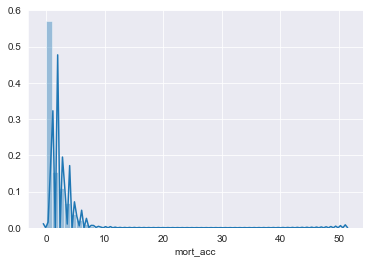

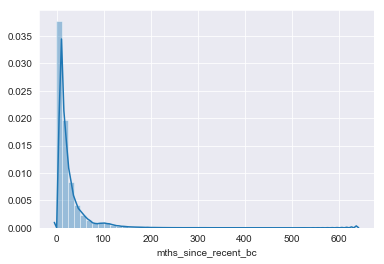

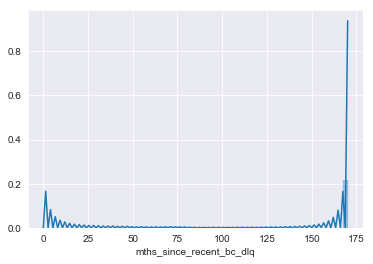

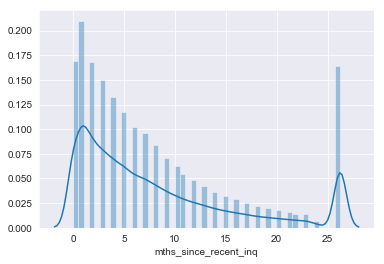

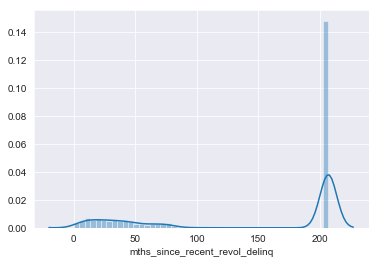

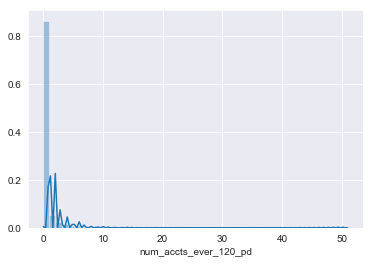

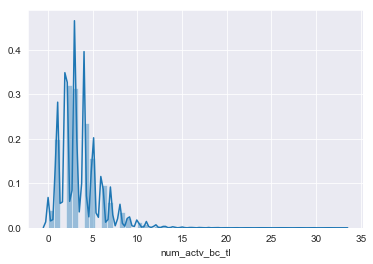

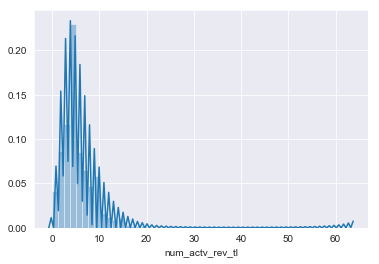

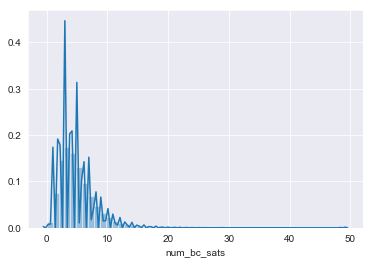

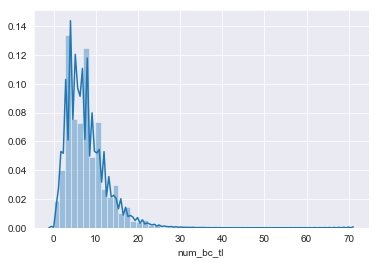

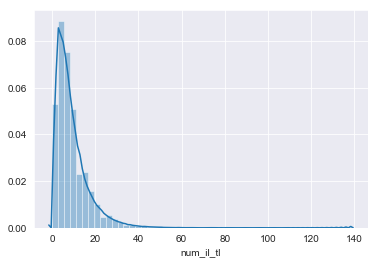

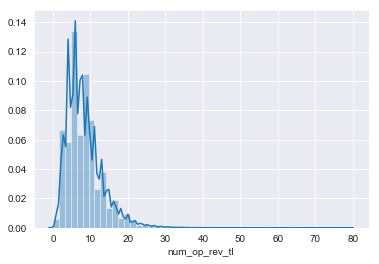

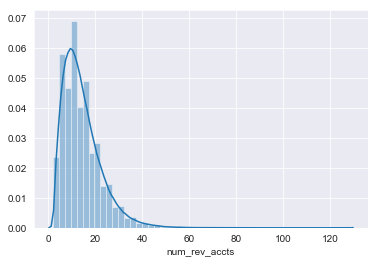

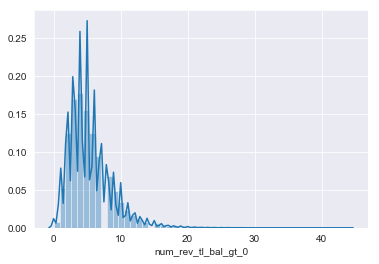

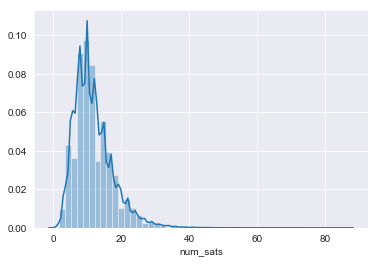

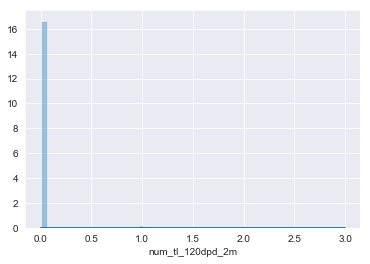

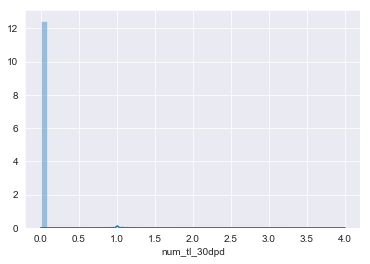

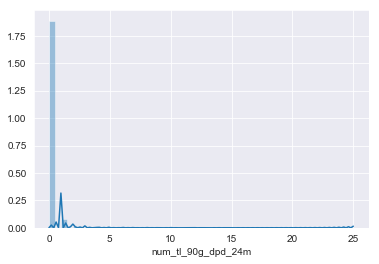

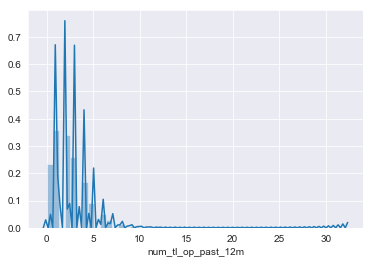

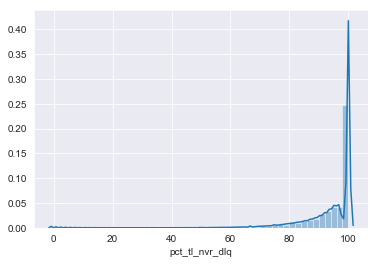

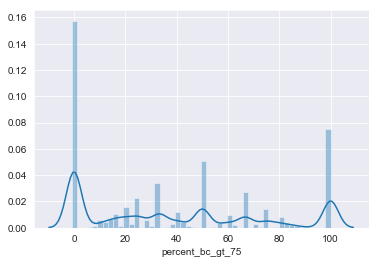

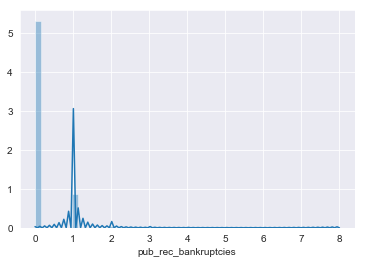

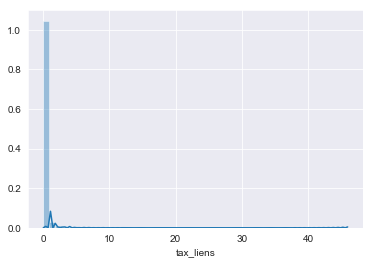

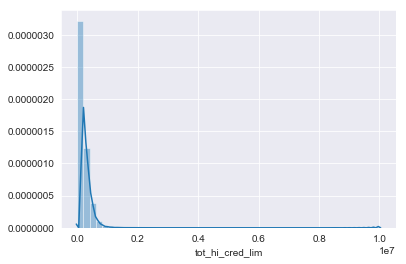

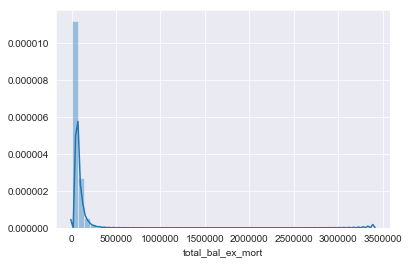

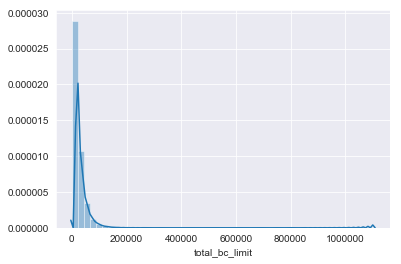

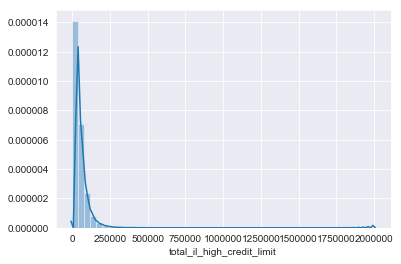

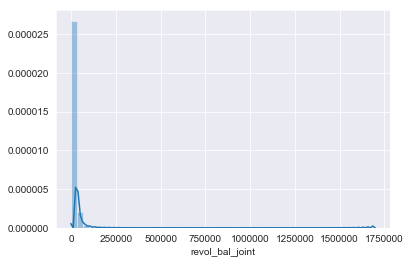

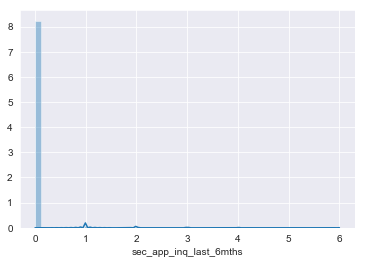

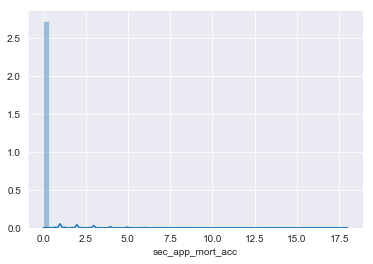

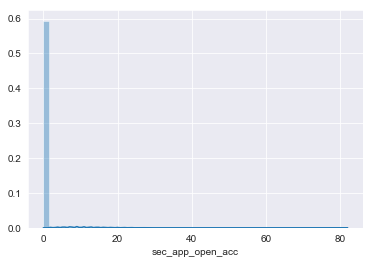

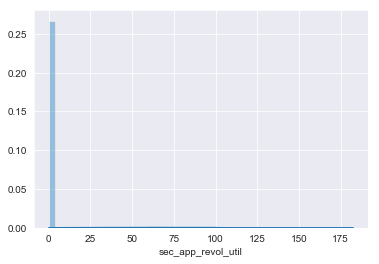

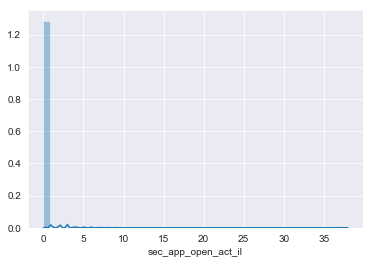

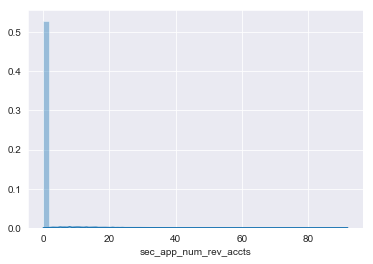

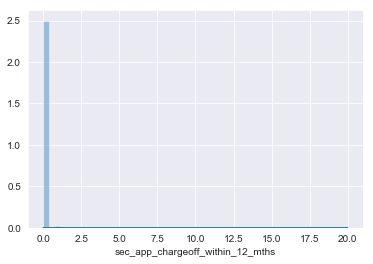

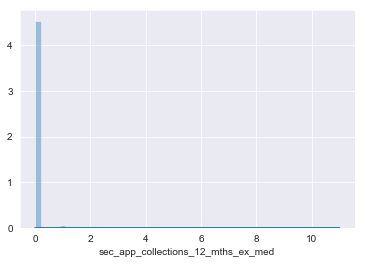

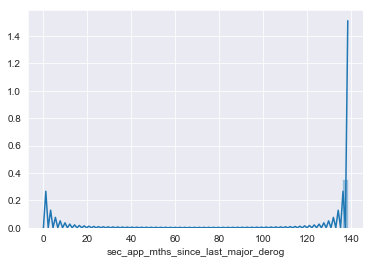

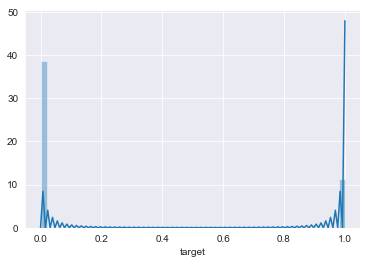

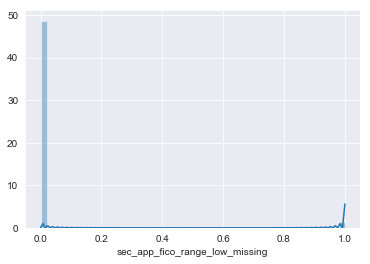

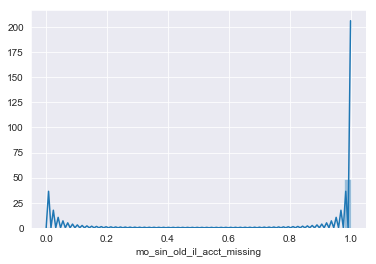

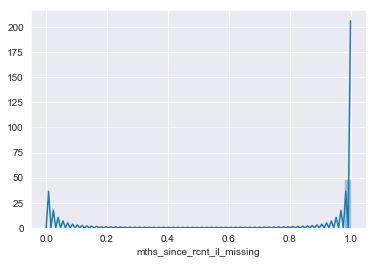

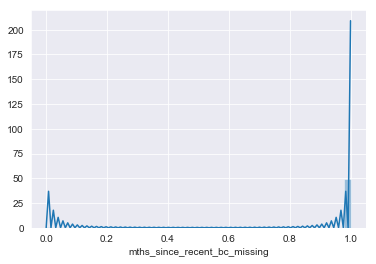

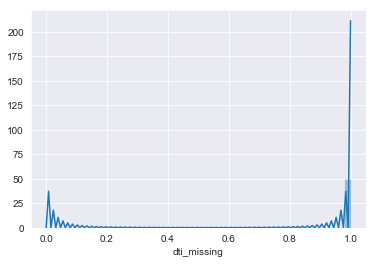

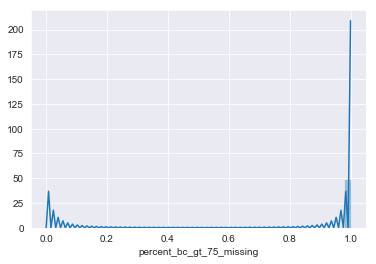

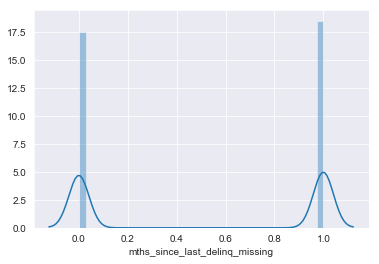

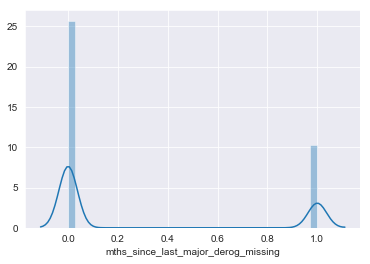

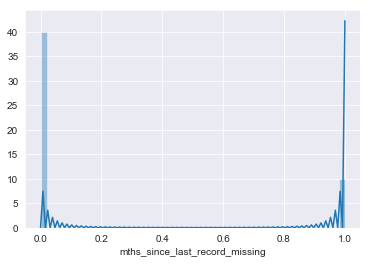

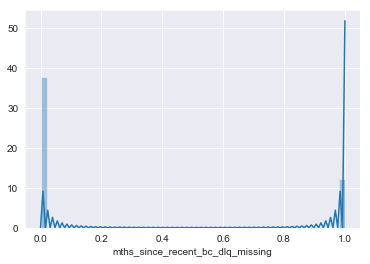

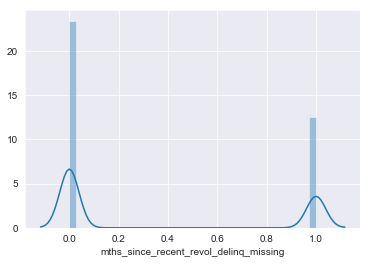

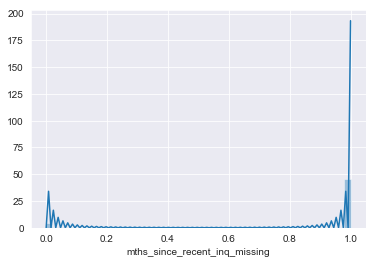

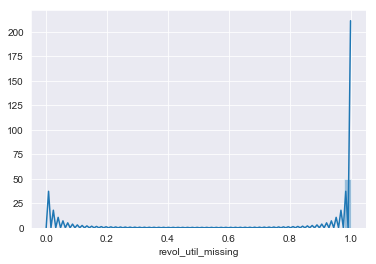

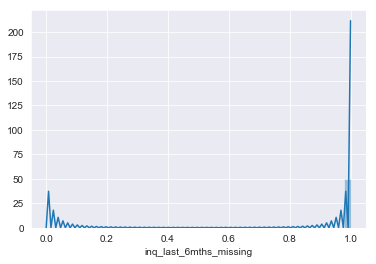

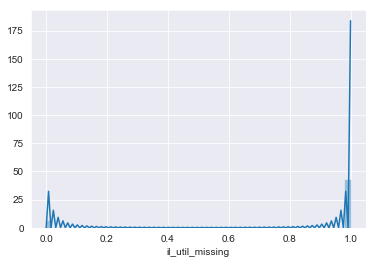

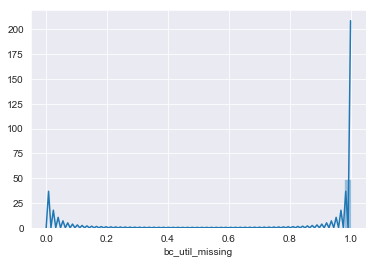

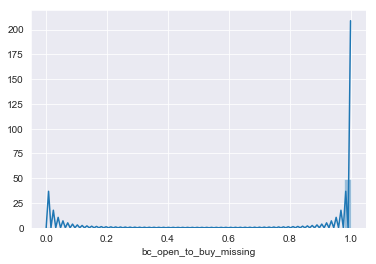

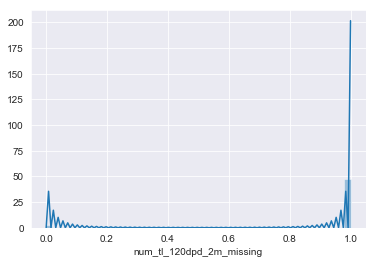

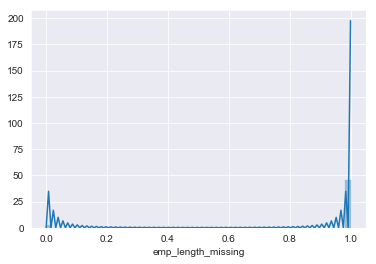

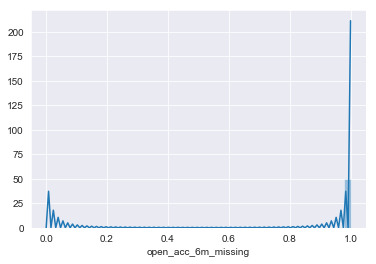

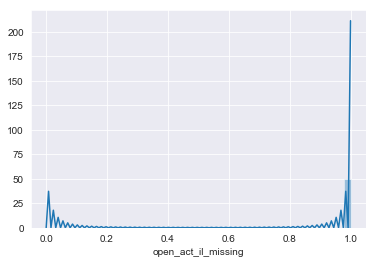

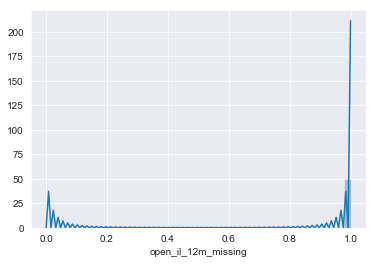

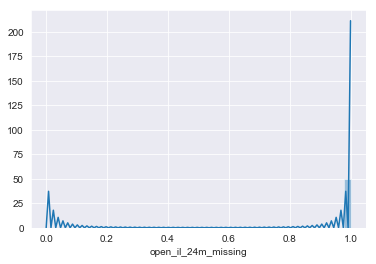

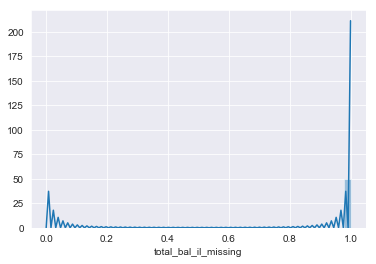

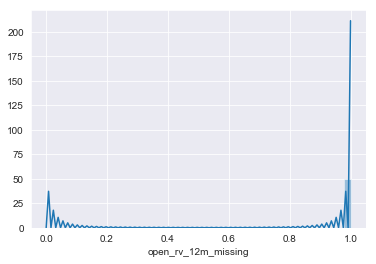

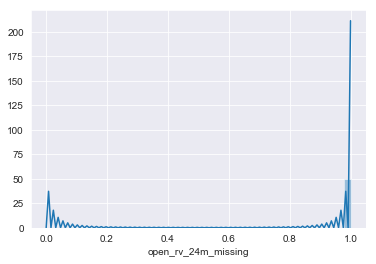

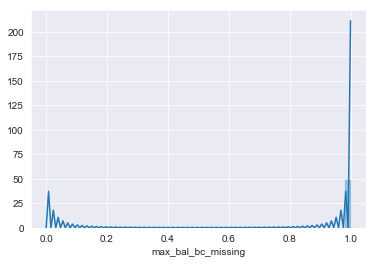

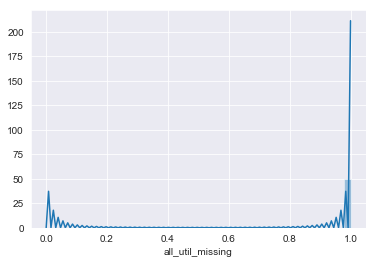

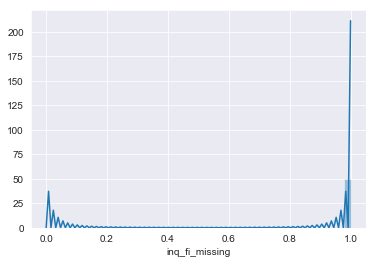

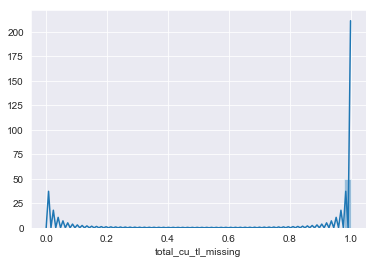

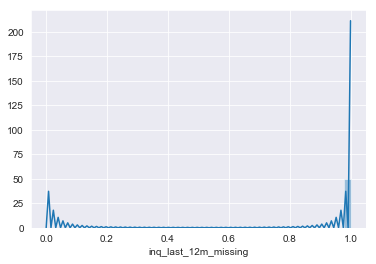

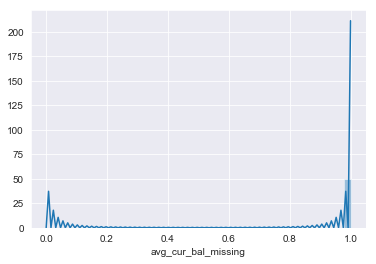

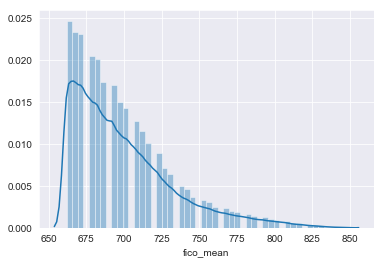

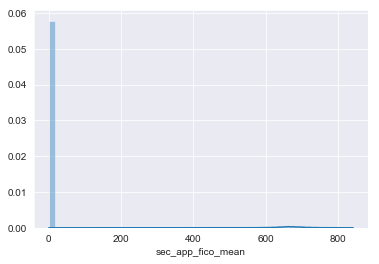

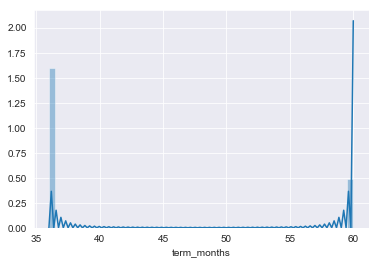

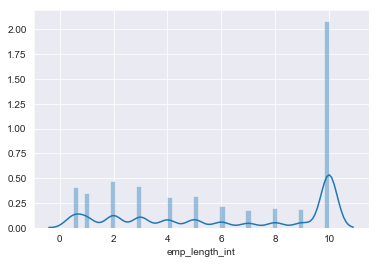

In [190]:
num_lending_club = lending_club.select_dtypes(include=['int64','float64']).copy()

for i, column in enumerate(num_lending_club.columns):
    plt.figure(i)
    sns.distplot(num_lending_club[column])

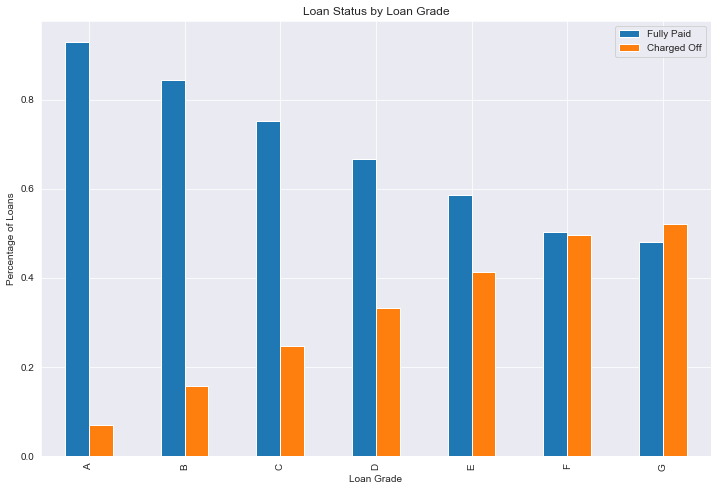

In [191]:
# Group dataframe by grade to see distribution of grade versus paid or charged off

loan_grade = lending_club.groupby(['grade'])['target'].value_counts(normalize=True).unstack('target')

# Plot loan grade and loan status
loan_grade.plot(kind='bar', stacked=False, figsize=(12,8))
plt.ylabel('Percentage of Loans')
plt.xlabel('Loan Grade')
plt.title('Loan Status by Loan Grade')
plt.legend(('Fully Paid', 'Charged Off'), loc='upper right')
plt.show()

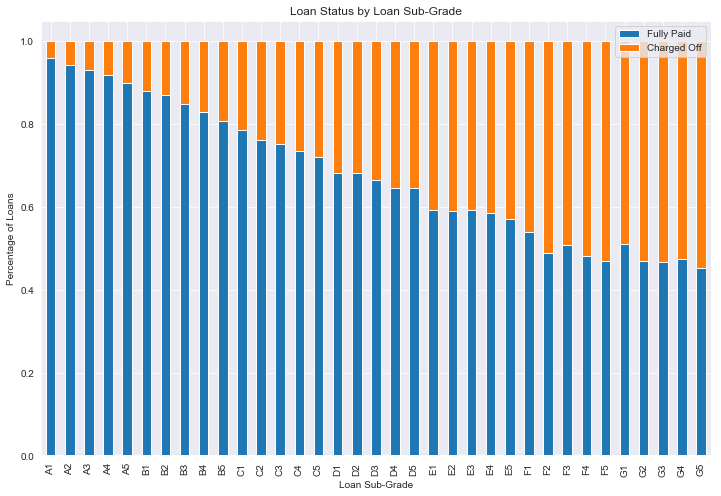

In [192]:
# Group dataframe by subgrade to see distribution of grade versus paid or charged off

loan_grade = lending_club.groupby(['sub_grade'])['target'].value_counts(normalize=True).unstack('target')

# Plot loan grade and loan status
loan_grade.plot(kind='bar', stacked=True, figsize=(12,8))
plt.ylabel('Percentage of Loans')
plt.xlabel('Loan Sub-Grade')
plt.title('Loan Status by Loan Sub-Grade')
plt.legend(('Fully Paid', 'Charged Off'), loc='upper right')
plt.show()

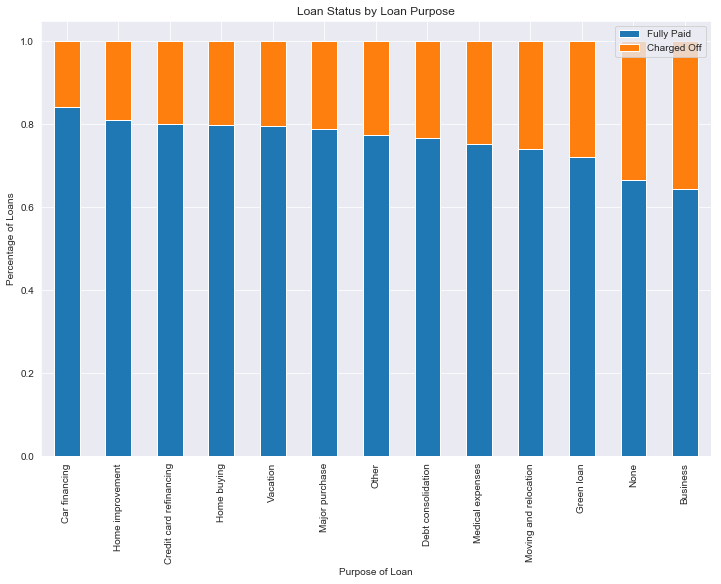

In [193]:
# Group dataframe by loan title to see distribution of title versus paid or charged off

loan_purpose = lending_club.groupby(['title'])['target'].value_counts(normalize=True).unstack('target')
loan_purpose.sort_values(1, ascending=True, inplace=True)

# Plot loan grade and loan status
loan_purpose.plot(kind='bar', stacked=True, figsize=(12,8))
plt.ylabel('Percentage of Loans')
plt.xlabel('Purpose of Loan')
plt.title('Loan Status by Loan Purpose')
plt.legend(('Fully Paid', 'Charged Off'), loc='upper right')
plt.show()

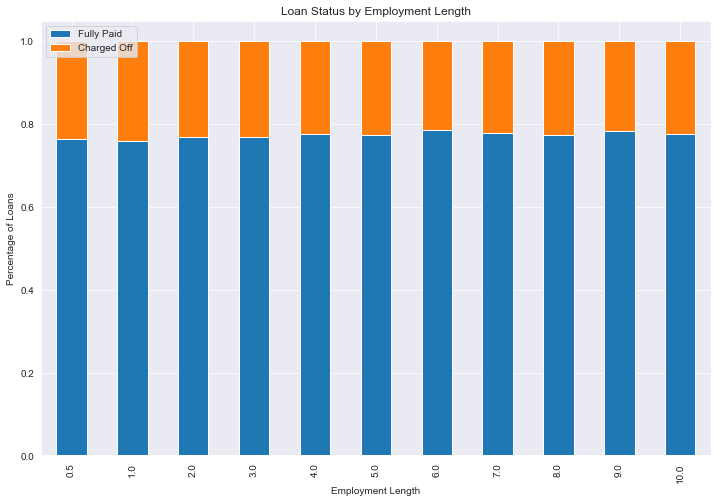

In [194]:
# Groupby employment length and target
emp_length = lending_club.groupby(['emp_length_int'])['target'].value_counts(normalize=True).unstack('target')

# Plot loan grade and loan status
emp_length.plot(kind='bar', stacked=True, figsize=(12,8))
plt.ylabel('Percentage of Loans')
plt.xlabel('Employment Length')
plt.title('Loan Status by Employment Length')
plt.legend(('Fully Paid', 'Charged Off'), loc='upper left')
plt.show()

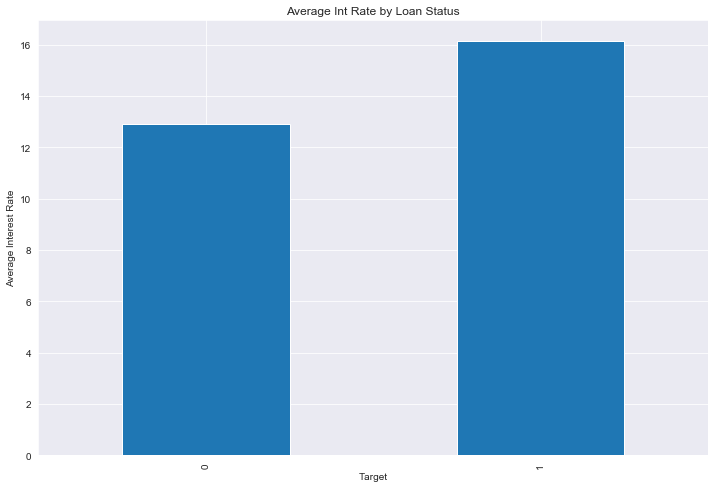

In [195]:
# Group dataframe by grade to see distribution of grade versus paid or charged off

int_rate = lending_club.groupby(['target'])['int_rate'].mean()

# Plot loan grade and loan status
int_rate.plot(kind='bar', figsize=(12,8))
plt.ylabel('Average Interest Rate')
plt.xlabel('Target')
plt.title('Average Int Rate by Loan Status')
plt.show()

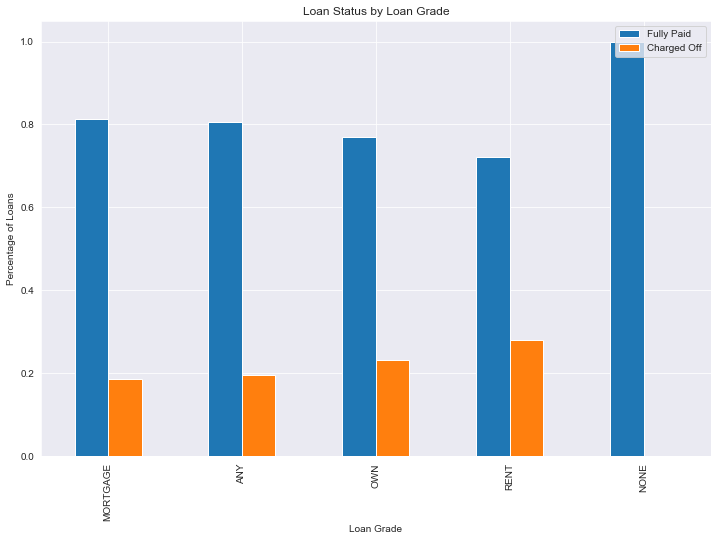

In [196]:
# Group dataframe by home ownership to see distribution of grade versus paid or charged off

loan_grade = lending_club.groupby(['home_ownership'])['target'].value_counts(normalize=True).unstack('target')
loan_grade.sort_values(1, ascending=True, inplace=True)

# Plot loan grade and loan status
loan_grade.plot(kind='bar', stacked=False, figsize=(12,8))
plt.ylabel('Percentage of Loans')
plt.xlabel('Loan Grade')
plt.title('Loan Status by Loan Grade')
plt.legend(('Fully Paid', 'Charged Off'), loc='upper right')
plt.show()

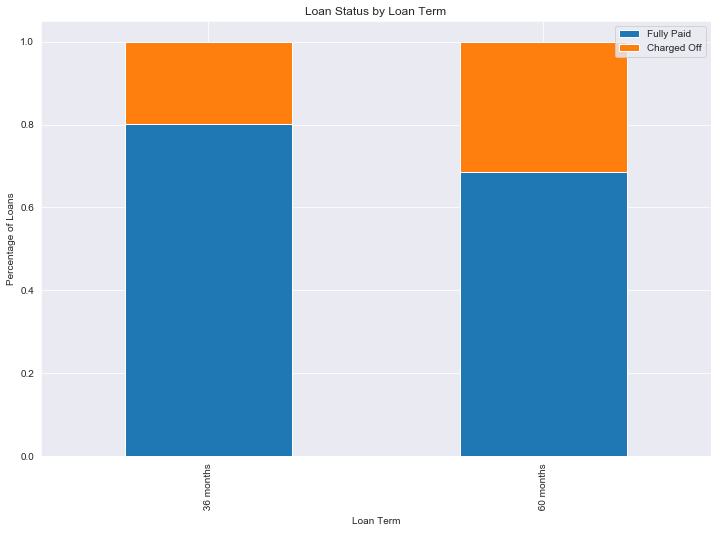

In [197]:
# Group dataframe by home ownership to see distribution of grade versus paid or charged off

loan_term = lending_club.groupby(['term'])['target'].value_counts(normalize=True).unstack('target')
loan_term.sort_values(1, ascending=True, inplace=True)

# Plot loan grade and loan status
loan_term.plot(kind='bar', stacked=True, figsize=(12,8))
plt.ylabel('Percentage of Loans')
plt.xlabel('Loan Term')
plt.title('Loan Status by Loan Term')
plt.legend(('Fully Paid', 'Charged Off'), loc='upper right')
plt.show()

In [198]:
cat_lending_club = lending_club.select_dtypes(include=['object']).copy()
cat_lending_club['target'] = lending_club['target']

num_lending_club = lending_club.select_dtypes(include=['int64','float64']).copy()

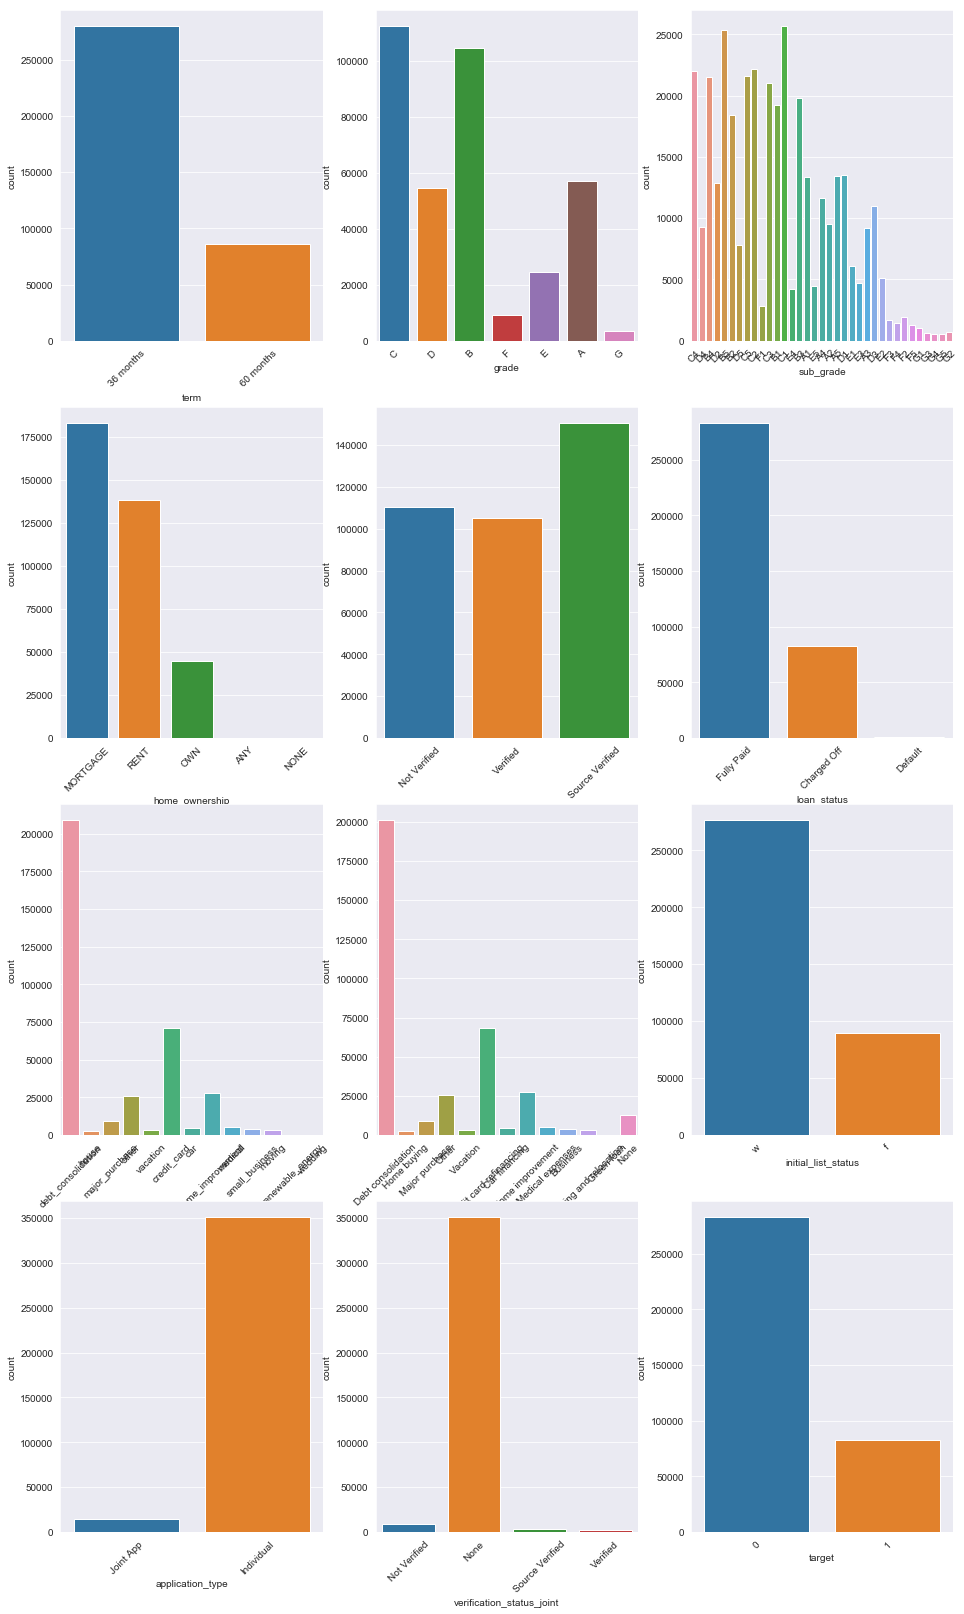

In [199]:
plot_cat_lending_club = cat_lending_club.drop(['url','emp_title','zip_code','addr_state'], axis=1)

fig, ax = plt.subplots(4, 3, figsize=(16, 28))
for variable, subplot in zip(plot_cat_lending_club, ax.flatten()):
    sns.countplot(plot_cat_lending_club[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(45)

# Feature Engineering

In [200]:
lending_club['emp_title'] = lending_club['emp_title'].str.lower() # convert all characters to lowercase
lending_club['emp_title'] = lending_club['emp_title'].str.strip() # strip whitespace before and after characters
lending_club['emp_title'] = lending_club['emp_title'].str.replace('nurse', 'registered nurse') # replace characters
lending_club['emp_title'] = lending_club['emp_title'].str.replace('rn', 'registered nurse') # replace characters
lending_club['emp_title'] = lending_club['emp_title'].str.replace('lvn', 'registered nurse') # replace characters
lending_club['emp_title'] = lending_club['emp_title'].str.replace('lpn', 'registered nurse') # replace characters
lending_club['emp_title'] = lending_club['emp_title'].str.replace('cna', 'registered nurse') # replace characters
lending_club['emp_title'] = lending_club['emp_title'].str.replace('registered nurse practitioner', 'registered nurse') # replace characters
lending_club['emp_title'] = lending_club['emp_title'].str.replace('cna', 'registered nurse') # replace characters


In [201]:
lending_club.emp_title.nunique()

80229

In [202]:
with pd.option_context('display.max_rows', 500, 'display.max_columns', None): 
    print(lending_club.emp_title.value_counts())

none                                                24564
manager                                              8423
teacher                                              7970
registered nurse                                     6045
owner                                                5358
driver                                               4314
supervisor                                           4202
registered registered nurse                          3971
sales                                                3667
project manager                                      2547
office manager                                       2395
general manager                                      2345
truck driver                                         2301
director                                             1888
sales manager                                        1702
engineer                                             1669
operations manager                                   1551
president     

In [203]:
#lending_club_fe = lending_club

In [204]:
# log transformation
log_trans = ['annual_inc', 'loan_amnt', 'revol_bal', 'total_acc', 'annual_inc_joint', 
             'tot_coll_amt', 'tot_cur_bal', 'total_bal_il','il_util', 'max_bal_bc', 
             'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'delinq_amnt', 'tot_hi_cred_lim',
             'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'revol_bal_joint']

for col in log_trans:
    lending_club['log_'+ col] = np.log(lending_club[col])

In [205]:
# convert datetimes to numerics

date_convert = ['issue_d','earliest_cr_line','last_credit_pull_d','sec_app_earliest_cr_line']

for col in date_convert:
    lending_club[col+'year'] = pd.DatetimeIndex(lending_club[col]).year
    lending_club[col+'year'] = pd.DatetimeIndex(lending_club[col]).month
    lending_club[col+'year'] = pd.DatetimeIndex(lending_club[col]).day
    
lending_club.drop(['issue_d','earliest_cr_line','last_credit_pull_d','sec_app_earliest_cr_line'], axis=1, inplace=True)

In [206]:
lending_club['total_int'] = (lending_club['installment'] * lending_club['term_months']) - lending_club['loan_amnt']

loan_pct = ['loan_amnt', 'installment', 'annual_inc', 'revol_bal', 'tot_coll_amt', 'tot_cur_bal', 'total_bal_il', 'max_bal_bc',
             'total_rev_hi_lim', 'avg_cur_bal', 'bc_open_to_buy', 'delinq_amnt', 'tot_hi_cred_lim', 'total_bal_ex_mort',
             'total_bc_limit', 'tot_hi_cred_lim', 'total_il_high_credit_limit']

for col in loan_pct:
    lending_club['pmt_pct_'+col] = lending_club['installment'] / lending_club[col] 
    lending_club['loan_pct_'+col] = lending_club['loan_amnt'] / lending_club[col]
    
lending_club['dti_adjusted'] = lending_club['dti'] + lending_club['pmt_pct_annual_inc']

lending_club['tot_cur_bal_adj'] = lending_club['loan_amnt'] + lending_club['tot_cur_bal']

lending_club['mortgage_bal'] = lending_club['tot_cur_bal'] - lending_club['total_bal_ex_mort']

lending_club['inc_pct_mortgage'] = lending_club['annual_inc'] / lending_club['mortgage_bal']


In [207]:
enc_cat_cols = ['term','grade','sub_grade','home_ownership','verification_status','purpose','initial_list_status',
                'application_type','verification_status_joint']

dummies = pd.get_dummies(lending_club[enc_cat_cols])

lending_club.drop(['title','term','grade','sub_grade','home_ownership','verification_status','purpose',
                   'initial_list_status', 'application_type','verification_status_joint','loan_status'], axis=1, inplace=True)

lending_club = pd.concat([lending_club, dummies], axis=1)


In [208]:
lending_club.drop(['emp_title','url','zip_code','addr_state'], axis=1, inplace=True)

In [209]:
lending_club.info(356)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366098 entries, 78 to 103544
Data columns (total 254 columns):
id                                           int64
loan_amnt                                    int64
int_rate                                     float64
installment                                  float64
annual_inc                                   float64
dti                                          float64
delinq_2yrs                                  int64
inq_last_6mths                               float64
mths_since_last_delinq                       float64
mths_since_last_record                       float64
open_acc                                     int64
pub_rec                                      int64
revol_bal                                    int64
revol_util                                   float64
total_acc                                    int64
collections_12_mths_ex_med                   int64
mths_since_last_major_derog                  float64
an

In [210]:
col_mask = lending_club.isnull().any(axis=0)
row_mask = lending_club.isnull().any(axis=1)
lending_club.loc[row_mask, col_mask]

,last_credit_pull_dyear,inc_pct_mortgage
41052,1.000,nan
76791,1.000,nan
102609,1.000,nan
107906,1.000,nan
121993,1.000,nan
55047,1.000,nan
81983,1.000,nan
99745,1.000,nan
104979,1.000,nan
122356,1.000,nan


In [211]:
# need to deal with categorical features
X = lending_club.drop(['target'], axis=1)
y = lending_club.target

In [212]:
X.head()

,id,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,...,purpose_vacation,purpose_wedding,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,verification_status_joint_None,verification_status_joint_Not Verified,verification_status_joint_Source Verified,verification_status_joint_Verified
78,139495505,25000,16.140,880.660,60000.000,26.580,0,0.000,80.000,129.150,...,0,0,0,1,0,1,0,1,0,0
215,141094274,6000,20.890,225.720,49000.000,24.570,0,0.000,237.300,75.000,...,0,0,1,0,1,0,1,0,0,0
707,140665706,7200,11.550,237.600,49500.000,16.900,0,2.000,56.000,129.150,...,0,0,0,1,1,0,1,0,0,0
1249,141068612,14000,18.940,362.710,51000.000,26.260,0,0.000,67.000,129.150,...,0,0,0,1,1,0,1,0,0,0
1323,141061982,2400,12.730,80.560,88000.000,27.740,6,0.000,10.000,129.150,...,0,0,0,1,1,0,1,0,0,0


In [213]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.15, random_state=1)

In [214]:
x_train.info(127)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 248946 entries, 5644 to 87374
Data columns (total 253 columns):
id                                           int64
loan_amnt                                    int64
int_rate                                     float64
installment                                  float64
annual_inc                                   float64
dti                                          float64
delinq_2yrs                                  int64
inq_last_6mths                               float64
mths_since_last_delinq                       float64
mths_since_last_record                       float64
open_acc                                     int64
pub_rec                                      int64
revol_bal                                    int64
revol_util                                   float64
total_acc                                    int64
collections_12_mths_ex_med                   int64
mths_since_last_major_derog                  float64
a

In [215]:
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3,
    random_state = 1337)
    
lr = LogisticRegression()

In [216]:
single_mdl_report = pd.DataFrame(columns=[
    'col_nm',
    'cardinality',
    'mean',
    'stddev',
    'min',
    'p5',
    'p25',
    'p50',
    'p75',
    'p95',
    'max',
    'kurtosis',
    'skew',
    'tree_auc',
    'tree_logloss',
    'min_prob_tree',
    'max_prob_tree',
    'lm_auc',
    'lm_logloss',
    'min_prob_lm',
    'max_prob_lm'])

## single variable model fitting
for col_nm in x_train.columns:
    print('VARIABLE: ' + col_nm)
    df_pre = x_train.loc[:, col_nm]
    x = x_train.loc[:, col_nm]
    x = np.array(x).reshape(-1, 1)
    y = y_train
    #print('FITTING RANDOM FOREST MODEL...')
    #rf_mdl = rf.fit(x, y)
    #rf_probs = rf_mdl.predict_proba(x)[:, 1]
    #rf_preds = rf_mdl.predict(x)
    #rf_log_loss = log_loss(
        #y_true=y,
        #y_pred=rf_probs,
        #labels=[0, 1])
    #fpr, tpr, thresholds = roc_curve(y, rf_probs, pos_label=1)
    #rf_auc = auc(fpr, tpr)
    print('FITTING DECISION TREE...')
    tree_mdl = decision_tree.fit(x, y)
    tree_probs = tree_mdl.predict_proba(x)[:, 1]
    tree_preds = tree_mdl.predict(x)
    tree_log_loss = log_loss(
        y_true=y,
        y_pred=tree_probs,
        labels=[0, 1]
    )
    fpr, tpr, thresholds = roc_curve(y, tree_probs, pos_label=1)
    tree_auc = auc(fpr, tpr)
    tree_probs = pd.DataFrame(tree_probs)
    df_pre = pd.concat([df_pre.reset_index(drop=True), tree_probs], axis=1)
    df_pre.columns = [col_nm, "tree_probs"]
    min_prob = df_pre.loc[:, "tree_probs"].min()
    max_prob = df_pre.loc[:, "tree_probs"].max()
    print('FITTING LINEAR MODEL...')
    linearmdl = lr.fit(x, y)
    lm_probs = linearmdl.predict_proba(x)[:, 1]
    lm_preds = linearmdl.predict(x)
    lm_log_loss = log_loss(
        y_true=y,
        y_pred=lm_probs,
        labels=[0, 1]
    )
    fpr, tpr, thresholds = roc_curve(y, lm_probs, pos_label=1)
    lm_auc = auc(fpr, tpr)
    df_pre = x_train.loc[:, [col_nm]]
    lm_probs = pd.DataFrame(lm_probs)
    df_pre = pd.concat([df_pre.reset_index(drop=True), lm_probs], axis=1)
    df_pre.columns = [col_nm, "lm_probs"]
    min_prob_lm = df_pre.loc[:, "lm_probs"].min()
    max_prob_lm = df_pre.loc[:, "lm_probs"].max()
    cardinality = x_train.loc[:, col_nm].nunique()
    col_mean, stddev, min, p25, p50, p75, max = x_train.loc[:, col_nm].describe()[[1, 2, 3, 4, 5, 6, 7]]
    skew = x_train.loc[:, col_nm].skew()
    kurt = x_train.loc[:, col_nm].kurt()
    p5 = x_train.loc[:, col_nm].quantile(0.05)
    p95 = x_train.loc[:, col_nm].quantile(0.95)
    tmp = pd.DataFrame(columns=[
        'col_nm',
        'cardinality',
        'mean',
        'stddev',
        'min',
        'p5',
        'p25',
        'p50',
        'p75',
        'p95',
        'max',
        'kurtosis',
        'skew',
        'tree_auc',
        'tree_logloss',
        'min_prob_tree',
        'max_prob_tree',
        'lm_auc',
        'lm_logloss',
        'min_prob_lm',
        'max_prob_lm'
    ])
    tmp.loc[0] = [
        col_nm, cardinality, col_mean, stddev, min, p5, p25, p50,
        p75, p95, max, kurt, skew,
        tree_auc, tree_log_loss,
        min_prob, max_prob, lm_auc, lm_log_loss,
        min_prob_lm, max_prob_lm
    ]
    single_mdl_report = single_mdl_report.append(tmp, ignore_index=True)
    print(col_nm + ' COMPLETE. NEXT VAR...')
    print("")
print("SINGLE VARIABLE MODELS DONE, SAVING FILE...")
## output to csv
single_mdl_report.to_csv("/Users/scotthongola/Documents/Thinkful/supervised_learning/SL_capstone/single_mdl_report/eda_single_var_report.csv",
                         index=False)
                         
                         

VARIABLE: id
FITTING DECISION TREE...
FITTING LINEAR MODEL...
id COMPLETE. NEXT VAR...

VARIABLE: loan_amnt
FITTING DECISION TREE...
FITTING LINEAR MODEL...
loan_amnt COMPLETE. NEXT VAR...

VARIABLE: int_rate
FITTING DECISION TREE...
FITTING LINEAR MODEL...
int_rate COMPLETE. NEXT VAR...

VARIABLE: installment
FITTING DECISION TREE...
FITTING LINEAR MODEL...
installment COMPLETE. NEXT VAR...

VARIABLE: annual_inc
FITTING DECISION TREE...
FITTING LINEAR MODEL...
annual_inc COMPLETE. NEXT VAR...

VARIABLE: dti
FITTING DECISION TREE...
FITTING LINEAR MODEL...
dti COMPLETE. NEXT VAR...

VARIABLE: delinq_2yrs
FITTING DECISION TREE...
FITTING LINEAR MODEL...
delinq_2yrs COMPLETE. NEXT VAR...

VARIABLE: inq_last_6mths
FITTING DECISION TREE...
FITTING LINEAR MODEL...
inq_last_6mths COMPLETE. NEXT VAR...

VARIABLE: mths_since_last_delinq
FITTING DECISION TREE...
FITTING LINEAR MODEL...
mths_since_last_delinq COMPLETE. NEXT VAR...

VARIABLE: mths_since_last_record
FITTING DECISION TREE...
FITTIN

FITTING LINEAR MODEL...
total_il_high_credit_limit COMPLETE. NEXT VAR...

VARIABLE: revol_bal_joint
FITTING DECISION TREE...
FITTING LINEAR MODEL...
revol_bal_joint COMPLETE. NEXT VAR...

VARIABLE: sec_app_inq_last_6mths
FITTING DECISION TREE...
FITTING LINEAR MODEL...
sec_app_inq_last_6mths COMPLETE. NEXT VAR...

VARIABLE: sec_app_mort_acc
FITTING DECISION TREE...
FITTING LINEAR MODEL...
sec_app_mort_acc COMPLETE. NEXT VAR...

VARIABLE: sec_app_open_acc
FITTING DECISION TREE...
FITTING LINEAR MODEL...
sec_app_open_acc COMPLETE. NEXT VAR...

VARIABLE: sec_app_revol_util
FITTING DECISION TREE...
FITTING LINEAR MODEL...
sec_app_revol_util COMPLETE. NEXT VAR...

VARIABLE: sec_app_open_act_il
FITTING DECISION TREE...
FITTING LINEAR MODEL...
sec_app_open_act_il COMPLETE. NEXT VAR...

VARIABLE: sec_app_num_rev_accts
FITTING DECISION TREE...
FITTING LINEAR MODEL...
sec_app_num_rev_accts COMPLETE. NEXT VAR...

VARIABLE: sec_app_chargeoff_within_12_mths
FITTING DECISION TREE...
FITTING LINEAR M

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [ ]:
single_mdl_report.set_index(['col_nm'], inplace=True)

In [ ]:
single_mdl_report.head()

In [ ]:
single_mdl_report.describe()

In [ ]:
single_mdl_report.tree_auc.nlargest(25)

In [ ]:
single_mdl_report.tree_auc.nlargest(25)

In [224]:
lending_club.log_annual_inc.value_counts('inf')

11.002   0.039
10.820   0.033
11.082   0.029
11.156   0.028
11.290   0.027
11.225   0.027
10.597   0.024
10.915   0.023
10.714   0.023
11.513   0.021
11.408   0.020
11.350   0.019
11.695   0.017
10.463   0.015
11.608   0.014
10.309   0.014
10.859   0.013
10.779   0.011
10.645   0.011
11.462   0.011
11.184   0.011
11.918   0.011
11.035   0.009
11.736   0.009
11.775   0.009
11.562   0.008
10.491   0.008
10.968   0.007
10.545   0.007
11.127   0.007
          ... 
11.454   0.000
11.625   0.000
10.463   0.000
11.741   0.000
10.576   0.000
9.285    0.000
11.063   0.000
11.374   0.000
11.858   0.000
10.871   0.000
11.931   0.000
11.906   0.000
11.696   0.000
10.749   0.000
11.338   0.000
11.057   0.000
10.596   0.000
11.211   0.000
10.793   0.000
10.820   0.000
10.732   0.000
11.083   0.000
12.059   0.000
11.688   0.000
11.406   0.000
10.840   0.000
11.058   0.000
10.189   0.000
11.946   0.000
11.086   0.000
Name: log_annual_inc, Length: 24134, dtype: float64

In [ ]:
corrmat_lending_club = lending_club.corr()

plt.figure(figsize=(20,12))

# draw the heatmap using seaborn.
sns.heatmap(corrmat_lending_club, square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (lending club)")

plt.show()

In [ ]:
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrmat_lending_club, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 12))

# Generate a diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrmat_lending_club, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
# find highest correlation of numerical features with target variable
lending_club_corr = lending_club[lending_club.columns[1:]].corr()['target'][:]

with pd.option_context('display.max_rows', None):  
    print(lending_club_corr.sort_values(ascending=False))

In [ ]:
cat_lending_club.emp_title.head(100)